In [13]:
import argparse
import os
from ast import arg

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from wlcorr import EncoderDecoderStaticDataset, EncoderDecoder1DCNN

from matplotlib import pyplot as plt
import numpy as np

In [2]:
class VRLoss(nn.Module):

    def __init__(self) -> None:
        super().__init__()
        self.cosinesim1 = nn.CosineSimilarity(dim=1, eps=1e-6)
        self.cosinesim2 = nn.CosineSimilarity(dim=2, eps=1e-6)

    def forward(self, output:torch.Tensor, target:torch.Tensor):
        b, n, _ = output.shape
        sim1 = self.cosinesim1(output, target)
        sim2 = self.cosinesim2(output, target)

        l = sim1.square().exp().mean() + sim2.square().exp().mean()
        return l

In [3]:
dataset = EncoderDecoderStaticDataset('/home/shivam/DKLabs/OilGasProject/WellLogCorrelation/data')
dataloader = DataLoader(dataset, batch_size = 10, shuffle = True, num_workers = 4)
data_len = len(dataloader)
log_n = int(data_len//2)

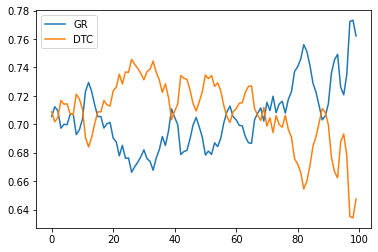

In [4]:
sample_data = dataset.__getitem__(0)
plt.plot(sample_data[0, :], label='GR')
plt.plot(sample_data[1, :], label='DTC')
plt.legend()
plt.show()

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
model = EncoderDecoder1DCNN(2, 50)
model.to(device)
model.train()

EncoderDecoder1DCNN(
  (encoder): Sequential(
    (0): Conv1d(2, 5, kernel_size=(10,), stride=(1,), padding=(9,))
    (1): SELU()
    (2): Conv1d(5, 10, kernel_size=(10,), stride=(1,), padding=(9,))
    (3): SELU()
    (4): Conv1d(10, 10, kernel_size=(10,), stride=(1,), padding=(9,))
    (5): SELU()
    (6): Conv1d(10, 10, kernel_size=(10,), stride=(1,), padding=(9,))
    (7): SELU()
    (8): Conv1d(10, 1, kernel_size=(10,), stride=(1,), padding=(9,))
    (9): SELU()
    (10): Linear(in_features=145, out_features=50, bias=True)
  )
  (decoder): Sequential(
    (0): ConvTranspose1d(1, 5, kernel_size=(10,), stride=(1,))
    (1): SELU()
    (2): ConvTranspose1d(5, 10, kernel_size=(10,), stride=(1,))
    (3): SELU()
    (4): ConvTranspose1d(10, 10, kernel_size=(10,), stride=(1,))
    (5): SELU()
    (6): ConvTranspose1d(10, 5, kernel_size=(10,), stride=(1,))
    (7): SELU()
    (8): ConvTranspose1d(5, 5, kernel_size=(10,), stride=(1,))
    (9): SELU()
    (10): ConvTranspose1d(5, 2, kernel

In [7]:
criterion =  torch.nn.MSELoss() # Loss function
params_list = model.parameters() # model parameters
optimizer = optim.AdamW(params_list, lr = 0.0007, weight_decay=0.0001)

In [8]:
def compute_loss(dl, model, crt):
    total_loss = 0.
    cnt = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in dl:
            data = data.to(device)
            
            # calculate outputs by running images through the network
            output = model(data)

            loss = crt(output, data)
            
            # print(predicted, labels)
            total_loss += loss.item()*data.size(0)
            cnt += data.size(0)
    return total_loss/cnt

In [9]:
rll = []
total_loss = []
model.train()
for epoch in range(200):
    running_loss = 0.0
    for i, data in enumerate(dataloader):
        data = data.to(device) # Move data to target device

        # zero the parameter gradients
        optimizer.zero_grad()

        output = model(data)
        loss = criterion(output, data)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if i%log_n == log_n-1:
            rll += [epoch, i, running_loss]
            print(f'Epoch : {epoch}, Iteration : {i},Running loss : {running_loss}')
            running_loss = 0
    total_loss += [compute_loss(dataloader, model, criterion)]
    print(f'Total loss : {total_loss[-1]}')

Epoch : 0, Iteration : 4,Running loss : 2.374845325946808
Epoch : 0, Iteration : 9,Running loss : 1.9421758353710175
Total loss : 0.3171270769469592
Epoch : 1, Iteration : 4,Running loss : 1.2957449406385422
Epoch : 1, Iteration : 9,Running loss : 0.7168583422899246
Total loss : 0.08736420939771497
Epoch : 2, Iteration : 4,Running loss : 0.3646622970700264
Epoch : 2, Iteration : 9,Running loss : 0.24132798612117767
Total loss : 0.023407520175132215
Epoch : 3, Iteration : 4,Running loss : 0.1455723512917757
Epoch : 3, Iteration : 9,Running loss : 0.1143258037045598
Total loss : 0.026561270068798746
Epoch : 4, Iteration : 4,Running loss : 0.09780302038416266
Epoch : 4, Iteration : 9,Running loss : 0.1404655333608389
Total loss : 0.01747738673085613
Epoch : 5, Iteration : 4,Running loss : 0.15698397811502218
Epoch : 5, Iteration : 9,Running loss : 0.10019967006519437
Total loss : 0.019634730999871175
Epoch : 6, Iteration : 4,Running loss : 0.13535686675459146
Epoch : 6, Iteration : 9,Runn

Epoch : 52, Iteration : 9,Running loss : 0.018960737739689648
Total loss : 0.002834859755536427
Epoch : 53, Iteration : 4,Running loss : 0.00800389947835356
Epoch : 53, Iteration : 9,Running loss : 0.012461116653867066
Total loss : 0.0025261612395204754
Epoch : 54, Iteration : 4,Running loss : 0.019252733327448368
Epoch : 54, Iteration : 9,Running loss : 0.011079897871240973
Total loss : 0.0016398923162713039
Epoch : 55, Iteration : 4,Running loss : 0.006935225508641452
Epoch : 55, Iteration : 9,Running loss : 0.013009738409891725
Total loss : 0.002243455127594346
Epoch : 56, Iteration : 4,Running loss : 0.01989177823998034
Epoch : 56, Iteration : 9,Running loss : 0.009414846252184361
Total loss : 0.0035098199233678834
Epoch : 57, Iteration : 4,Running loss : 0.024026414204854518
Epoch : 57, Iteration : 9,Running loss : 0.0105384630151093
Total loss : 0.0021679374503389913
Epoch : 58, Iteration : 4,Running loss : 0.01641563535667956
Epoch : 58, Iteration : 9,Running loss : 0.0232670850

Epoch : 104, Iteration : 9,Running loss : 0.011315265786834061
Total loss : 0.001550146772963356
Epoch : 105, Iteration : 4,Running loss : 0.009656854206696153
Epoch : 105, Iteration : 9,Running loss : 0.009216962032951415
Total loss : 0.0015630937711221678
Epoch : 106, Iteration : 4,Running loss : 0.009791768272407353
Epoch : 106, Iteration : 9,Running loss : 0.009740197099745274
Total loss : 0.0014739666176883845
Epoch : 107, Iteration : 4,Running loss : 0.007961863360833377
Epoch : 107, Iteration : 9,Running loss : 0.006535095686558634
Total loss : 0.0014540467812793748
Epoch : 108, Iteration : 4,Running loss : 0.00653701409464702
Epoch : 108, Iteration : 9,Running loss : 0.0092761279665865
Total loss : 0.0017277487679574714
Epoch : 109, Iteration : 4,Running loss : 0.01361604913836345
Epoch : 109, Iteration : 9,Running loss : 0.005126237228978425
Total loss : 0.0015580126248319081
Epoch : 110, Iteration : 4,Running loss : 0.007608816318679601
Epoch : 110, Iteration : 9,Running loss

Total loss : 0.0018987044958131655
Epoch : 156, Iteration : 4,Running loss : 0.009128026955295354
Epoch : 156, Iteration : 9,Running loss : 0.00905547698494047
Total loss : 0.0020133468799996283
Epoch : 157, Iteration : 4,Running loss : 0.006740991782862693
Epoch : 157, Iteration : 9,Running loss : 0.009961139236111194
Total loss : 0.0016165484201486166
Epoch : 158, Iteration : 4,Running loss : 0.006338792736642063
Epoch : 158, Iteration : 9,Running loss : 0.008679258229676634
Total loss : 0.0016398031278798471
Epoch : 159, Iteration : 4,Running loss : 0.011357682524248958
Epoch : 159, Iteration : 9,Running loss : 0.005602208257187158
Total loss : 0.0021373147812519906
Epoch : 160, Iteration : 4,Running loss : 0.007226032030303031
Epoch : 160, Iteration : 9,Running loss : 0.006275229912716895
Total loss : 0.0013039951516809513
Epoch : 161, Iteration : 4,Running loss : 0.005141166679095477
Epoch : 161, Iteration : 9,Running loss : 0.00880172208417207
Total loss : 0.0013950233067366847
E

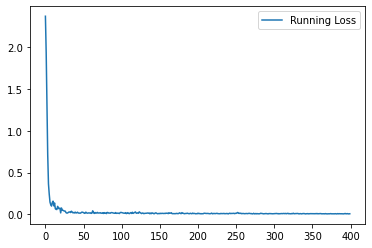

In [18]:
plt.plot(np.array(rll).reshape((-1, 3))[:, 2], label='Running Loss')
plt.legend()
plt.show()

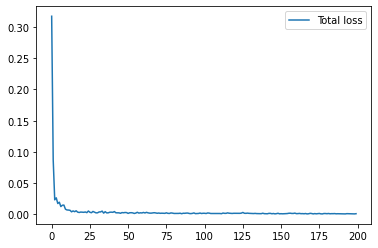

In [19]:
plt.plot(total_loss, label='Total loss')
plt.legend()
plt.show()

In [20]:
torch.save(model.state_dict(), './modelstate_l2_norm')

In [22]:
model.eval()

EncoderDecoder1DCNN(
  (encoder): Sequential(
    (0): Conv1d(2, 5, kernel_size=(10,), stride=(1,), padding=(9,))
    (1): SELU()
    (2): Conv1d(5, 10, kernel_size=(10,), stride=(1,), padding=(9,))
    (3): SELU()
    (4): Conv1d(10, 10, kernel_size=(10,), stride=(1,), padding=(9,))
    (5): SELU()
    (6): Conv1d(10, 10, kernel_size=(10,), stride=(1,), padding=(9,))
    (7): SELU()
    (8): Conv1d(10, 1, kernel_size=(10,), stride=(1,), padding=(9,))
    (9): SELU()
    (10): Linear(in_features=145, out_features=50, bias=True)
  )
  (decoder): Sequential(
    (0): ConvTranspose1d(1, 5, kernel_size=(10,), stride=(1,))
    (1): SELU()
    (2): ConvTranspose1d(5, 10, kernel_size=(10,), stride=(1,))
    (3): SELU()
    (4): ConvTranspose1d(10, 10, kernel_size=(10,), stride=(1,))
    (5): SELU()
    (6): ConvTranspose1d(10, 5, kernel_size=(10,), stride=(1,))
    (7): SELU()
    (8): ConvTranspose1d(5, 5, kernel_size=(10,), stride=(1,))
    (9): SELU()
    (10): ConvTranspose1d(5, 2, kernel

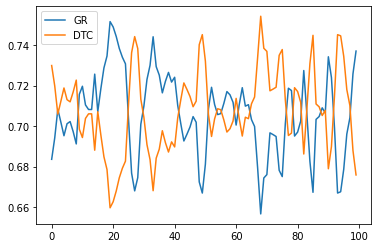

In [23]:
sample_data = dataset.__getitem__(0)
plt.plot(sample_data[0, :], label='GR')
plt.plot(sample_data[1, :], label='DTC')
plt.legend()
plt.show()

In [25]:
sample_data_ = sample_data.unsqueeze(dim=0).to(device)
reconst_data = model(sample_data_)
reconst_data = reconst_data.detach().cpu().squeeze(dim=0).numpy()

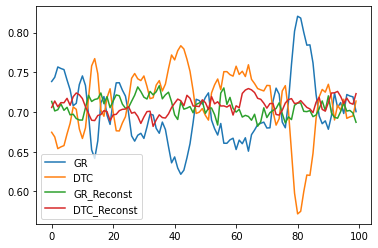

In [27]:
sample_data = dataset.__getitem__(0)
plt.plot(sample_data[0, :], label='GR')
plt.plot(sample_data[1, :], label='DTC')
plt.plot(reconst_data[0, :], label='GR_Reconst')
plt.plot(reconst_data[1, :], label='DTC_Reconst')
plt.legend()
plt.show()